In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
#from google.colab import drive
#drive.mount('/content/drive')

# Add Folder to the system path so we can load custome modules
#import sys
#sys.path.append('/content/drive/Shareddrives/WolfWorks\ Experimental/WWE\ 2023-24/Airbrakes/Launch\ Data/ColabCode')


In [17]:
# Read both of the tables
df_1 = pd.read_csv('./CatoPDF_Spring2022_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(0,9))
df_2 = pd.read_csv('./CatoPDF_Spring2022_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(9,18))

In [24]:
# Merge the dataframes
df_m = pd.merge(df_1, df_2.rename(columns={'time.1':'time'}), on='time',  how='left')

# Interpolate missing values (since we merged on different sized tables
df_m.set_index('time', inplace=True)
df_m.interpolate(method='index', inplace=True)
df_m.bfill(inplace=True)
df_m.reset_index(inplace=True)

# Constrain time to range we care about observing
tstart = 1450 #1461.25
tend = 1550 #1472.5
df_m = df_m[(df_m['time'] < tend) & (df_m['time'] > tstart)]

# Visually check that things look like
print(df_m.head())

              time   accel_x   accel_y   accel_z    gyro_x    gyro_y  \
62298  1450.000977  0.118013  0.045976 -9.785261 -0.480377  0.419746   
62299  1450.001953  0.111720  0.076803 -9.747754 -0.743052  0.197038   
62300  1450.003052  0.091082  0.129472 -9.762688 -0.816527  0.232145   
62301  1450.004028  0.090294  0.173115 -9.784898 -0.853695  0.216455   
62302  1450.005005  0.096537  0.210535 -9.791042 -0.835746  0.396840   

         gyro_z  gps  gps.1   altitude  estLinearAccelX  estLinearAccelY  \
62298  0.298899  0.0    4.0  35.718876        -0.304497        -0.158830   
62299  0.486555  0.0    4.0  35.718876        -0.297267        -0.124500   
62300  0.363688  0.0    4.0  35.718876        -0.308568        -0.084444   
62301  0.287782  0.0    4.0  35.718876        -0.318604        -0.048872   
62302  0.254113  0.0    4.0  35.718876        -0.330963         0.000405   

       estLinearAccelZ      roll     pitch       yaw  gps.2  
62298        -0.057293 -0.013480  0.043668  1.47

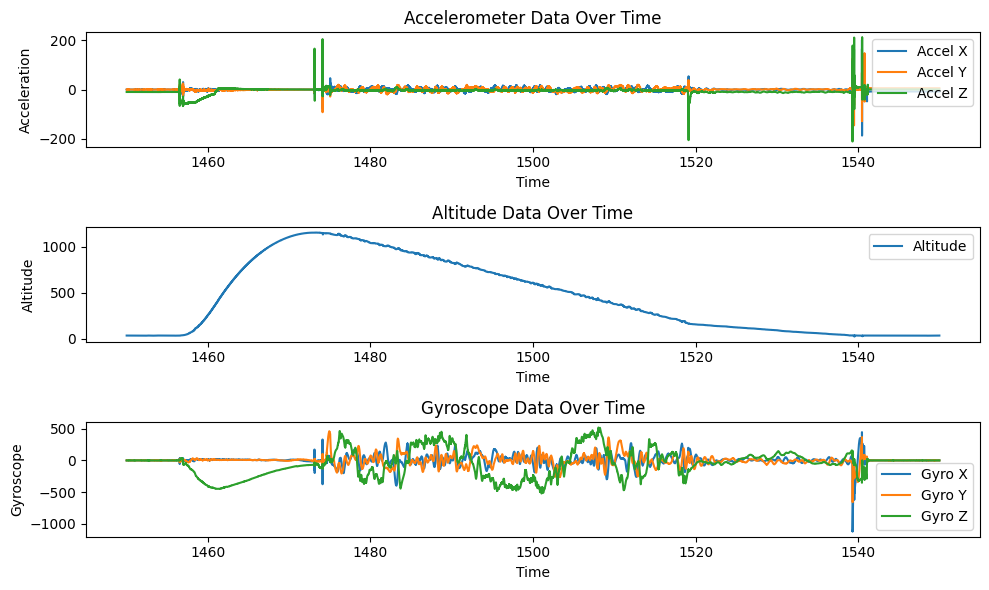

In [31]:
# Plot accelerometer data
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(df_m['time'], df_m['accel_x'], label='Accel X')
plt.plot(df_m['time'], df_m['accel_y'], label='Accel Y')
plt.plot(df_m['time'], df_m['accel_z'], label='Accel Z')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Accelerometer Data Over Time')

# Plot Altitude data
plt.subplot(3, 1, 2)
plt.plot(df_m['time'], df_m['altitude'], label='Altitude')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.title('Altitude Data Over Time')

# Plot gyroscope data
plt.subplot(3, 1, 3)
plt.plot(df_m['time'], df_m['gyro_x'], label='Gyro X')
plt.plot(df_m['time'], df_m['gyro_y'], label='Gyro Y')
plt.plot(df_m['time'], df_m['gyro_z'], label='Gyro Z')
plt.xlabel('Time')
plt.ylabel('Gyroscope')
plt.legend()
plt.title('Gyroscope Data Over Time')

# Show the plot
plt.tight_layout()
plt.show()

Below is testing for various fitting methods


1387.703003 36.228844
1387.703979 36.228844
1387.704956 36.228844
1387.706055 36.228844
1387.707031 36.228844
1387.708008 36.228844
1387.708984 36.228844
1387.709961 36.228844
1387.71106 36.228844
1387.712036 36.228844
1387.713013 36.228844


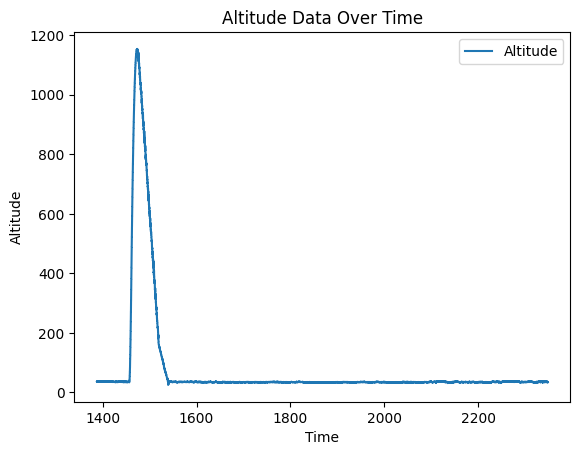

In [20]:
# Polynomial fit

plt.plot(df_m['time'], df_m['altitude'], label='Altitude')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.title('Altitude Data Over Time')

count = 0
for index, row in df_m.iterrows():
    print(row['time'], row['altitude'])
    count += 1
    if (count > 10):
      break

Below is some simulation code. The first block is for modules which you will need to run to load into the python environment first. Lower blocks will be used to run the actual code.

In [21]:
import numpy as np
'''
Module / Class created for simulating the flight of a rocket using 1D motion approximations.
All unites in SI / metric unless explicitly stated otherwise
'''
class rocket_model_1D:
    itmax = 10000 #maximum number of simulation iterations

    def __init__ (self, mass, area, drag_coeff, density_model = 1, gravtiy_model = 1):
        # Define the rocket
        self.mass = mass
        self.massi = 1/mass
        self.ref_area = area # reference area for the drag coefficient
        self.Cd = drag_coeff
        self.density_model = density_model
        self.gravity_model  = gravtiy_model
        self.state = np.array([0.0,0.0]) #state = np.array([position, velocity])

    def initialize(self, position, velocity):
      self.state[0] = position
      self.state[1] = velocity

    def set_timestep(self, dt):
      self.dt = dt

    def CdA(self):
      return self.Cd * self.ref_area

    def rho(self):
      if (self.density_model == 1):
        return 1.2
      else:
        return float('NaN')

    def g(self):
      if (self.gravity_model == 1):
       return 9.81
      else:
        return float('NaN')

    def drag_force(self, velocity):
      vmag = abs(velocity)
      return 0.5*self.rho()*vmag*velocity*self.CdA()

    def acceleration(self):
      return -self.drag_force(self.state[1])*self.massi - self.g()

    def euler_step(self):
      self.state += self.dt * np.array([self.state[1], self.acceleration()])

    def sim_to_apogee(self):
      iter = 0;
      self.height = []
      self.time = []

      self.height.append(self.state[0])
      self.time.append(0)

      while (self.state[1] > 0) and (iter < self.itmax):
        self.euler_step()

        self.height.append(self.state[0])
        self.time.append(self.time[iter] + dt)
        iter += 1

      return self.state[0]

Apogee: %f
 468.00148622811963


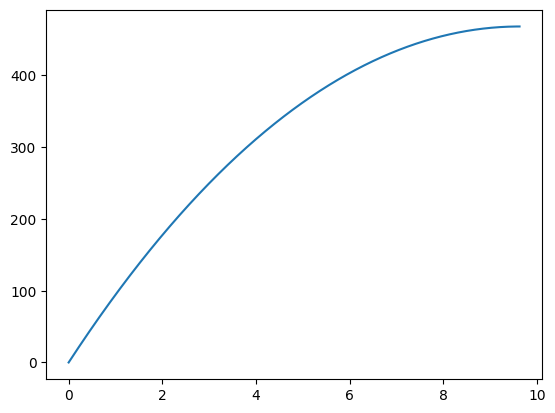

In [22]:
#Example code for running the 1D model

rkt_mass = 20     #kg
rxt_area = 0.1    #m
Cd = 0.06         #drag coefficient


test_rock = rocket_model_1D(rkt_mass, rxt_area, Cd)

h0 = 0   #m
v0 = 100 #m/s
test_rock.initialize(h0, v0)

dt = 0.001 #s
test_rock.set_timestep(dt)

test_apogee = test_rock.sim_to_apogee()
print("Apogee: %f\n", test_apogee)
plt.plot(test_rock.time, test_rock.height)